In [1]:
import seaborn as sns
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [2]:
train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'
test_path = '../../datasets/santander_customer_transaction_prediction/test.csv'

df_train = pd.read_csv(train_path)
X_train = df_train.drop(columns=['ID_code', 'target']).values
y_train = df_train['target'].values

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

4.029149542259755 28.386650457740245


(6.2993, 26.0791)

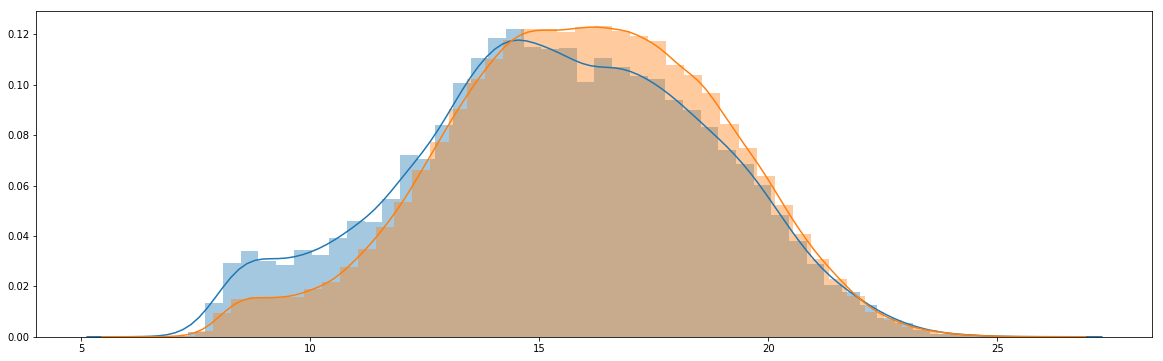

In [3]:
var_i = 198
plt.figure(figsize=(20,6))
sns.distplot(X_train[y_train==1, var_i], label = 't=1')
sns.distplot(X_train[y_train==0, var_i], label = 't=0')
mn,mx = plt.xlim()
print(mn,mx)
X_train[:, var_i].min(), X_train[:, var_i].max()

In [23]:
col = 'var_198'
FE_cal = 'var_198_FE'
value_counts = df_train[col].value_counts()
df_train['var_198_FE'] = df_train[col].map(value_counts)

In [25]:
value_counts.head()

16.8760    13
17.9382    11
14.1484    11
17.0855    11
17.0495    11
Name: var_198, dtype: int64

In [5]:
df_train[['var_198' ,'var_198_FE']].head()

,var_198,var_198_FE
0,12.7803,5
1,18.3560,2
2,14.7222,2
3,17.9697,2
4,17.9974,2


In [6]:
value_counts.head()

16.8760    13
17.9382    11
14.1484    11
17.0855    11
17.0495    11
Name: var_198, dtype: int64

In [7]:
sorted_values_with_counts = df_train[['var_198', 'var_198_FE']].sort_values('var_198')

[]

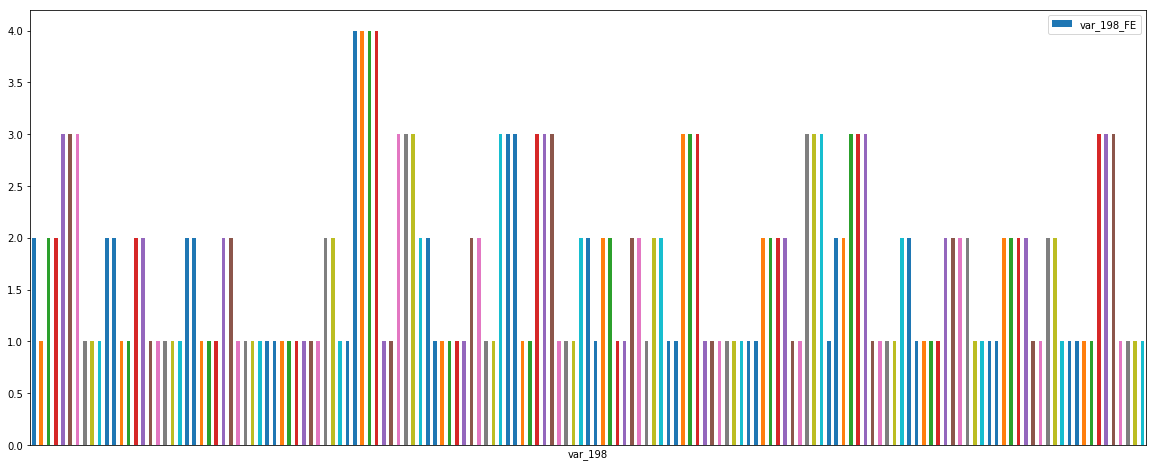

In [8]:
ax = sorted_values_with_counts.iloc[11947:12100].plot(x='var_198', y='var_198_FE', kind='bar', figsize=(20,8))
ax.set_xticks([])

In [9]:
mn,mx

(4.029149542259755, 28.386650457740245)

In [10]:
df_train['var_'+str(var_i)+'_FE'].nunique()

12

In [11]:
# mn,mx = X_train[:, var_i].min(), X_train[:, var_i].max()
mnFE = df_train['var_'+str(var_i)+'_FE'].min()
mxFE = df_train['var_'+str(var_i)+'_FE'].max()
step = 50
stepB = df_train['var_'+str(var_i)+'_FE'].max() - df_train['var_'+str(var_i)+'_FE'].min() + 1 # df_train['var_'+str(var_i)+'_FE'].nunique()
# stepB = df_train['var_'+str(var_i)+'_FE'].nunique()
w = (mx-mn)/step
x = w * (np.arange(0,step)+0.5) + mn
x2 = np.array([])
for i in range(stepB):
    x2 = np.concatenate([x,x2])
# 
df_grid = pd.DataFrame({'var_'+str(var_i):x2})
df_grid['var_'+str(var_i)+'_FE'] = mnFE + (mxFE-mnFE)/(stepB-1) * (df_grid.index//step)
df_grid['pred'] = 0

In [12]:
mn,mx, mnFE, mxFE, step, stepB

(4.029149542259755, 28.386650457740245, 1, 13, 50, 13)

In [13]:
param = {
    'learning_rate': 0.04,
    'num_leaves': 3,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 1.0,
    'max_depth': -1,
    'objective': 'binary',
    'verbosity': -10}
features = ['var_'+str(var_i),'var_'+str(var_i)+'_FE']
evals_result = {}
oof = np.zeros(len(df_train))
preds = np.zeros(len(df_test))

In [14]:
# 5-FOLD WITH MAGIC
for k in range(5):
    valid = df_train.iloc[k*40000:(k+1)*40000]
    train = df_train[ ~df_train.index.isin(valid.index) ]    
    trn_data  = lgb.Dataset(train[features], label=train['target'])
    val_data = lgb.Dataset(valid[features], label=valid['target'])     
    model = lgb.train(param, trn_data, 750, valid_sets = [trn_data, val_data], 
            verbose_eval=False, evals_result=evals_result)      
    x = evals_result['valid_1']['auc']
    best = x.index(max(x))
    print('k=',k,'best=',best)
    oof[k*40000:(k+1)*40000] = model.predict(valid[features], num_iteration=best)
    # preds += model.predict(df_test[features], num_iteration=best)/5.0
    df_grid['pred'] += model.predict(df_grid[features], num_iteration=best)/5.0

k= 0 best= 587
k= 1 best= 547
k= 2 best= 729
k= 3 best= 599
k= 4 best= 149


In [15]:
#df_grid.iloc[400:460]

In [16]:
val_auc = roc_auc_score(df_train['target'], oof)
print('VAR_'+str(var_i)+' with magic val_auc =',round(val_auc,5))
# VAR_198 with magic val_auc = 0.54872

VAR_198 with magic val_auc = 0.54872


In [17]:
x = df_grid['pred'].values
x = np.reshape(x,(stepB,step))
x = np.flip(x,axis=0)

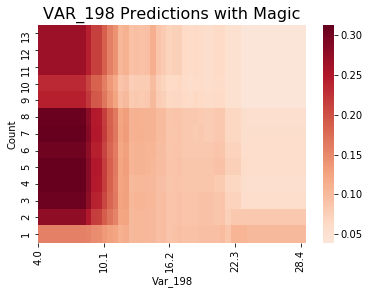

In [18]:
sns.heatmap(x, cmap='RdBu_r', center=0.0) 
plt.title('VAR_'+str(var_i)+' Predictions with Magic',fontsize=16)    
plt.xticks(np.linspace(0,49,5),np.round(np.linspace(mn,mx,5),1))
plt.xlabel('Var_'+str(var_i))
s = min(mxFE-mnFE+1,20)
plt.yticks(np.linspace(mnFE,mxFE,s)-0.5,np.linspace(mxFE,mnFE,s).astype('int'))
plt.ylabel('Count')
plt.show()

In [81]:
df_grid['var_198_FE'].unique()

array([ 1.        ,  2.09090909,  3.18181818,  4.27272727,  5.36363636,
        6.45454545,  7.54545455,  8.63636364,  9.72727273, 10.81818182,
       11.90909091, 13.        ])

In [11]:
# FREQUENCY ENCODE
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

test['target'] = -1
comb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)
for i in range(200): encode_FE(comb,'var_'+str(i),test)
train = comb[:len(train)]; del comb
print('Added 200 new magic features!')

NameError: name 'test' is not defined